In [111]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Data parameters
from tqdm import tqdm
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot8DimsNS_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config

from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
from utils.drift_evaluation_functions import multivar_score_based_MLP_drift_OOS
import os
import torch
config = get_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
time_ax = np.linspace(0, 1/256*(256),257)

In [94]:
type = "score"

In [113]:
assert (config.hurst == 0.5)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 110)
#assert (config.sin_space_scale == 25.)
#assert (config.feat_thresh == 1./100.)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
    *config.model_parameters)
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
device_id = "cpu"
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "EE" in file:
        print(file)
        entered = True
        scoreModel.load_state_dict(torch.load(os.path.join(model_dir, file)))
assert entered

/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110 40000
trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_05a_004b_250c_MLP_H4_CUp20_tl110_EENEp2823


In [114]:
import torch.nn.functional as F
def experiment_MLP_1D_drifts(config, es,Xs,good, onlyGauss=False):
    if config.has_cuda:
        device = 0#int(os.environ["LOCAL_RANK"])
    else:
        device = torch.device("cpu")
    Xs = torch.Tensor(Xs).to(device)
    good = good.to(device)
    diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
    ts_step = config.deltaT
    Xshape = Xs.shape[0]#config.ts_length
    num_taus = 1000

    num_diff_times = config.max_diff_steps
    Ndiff_discretisation = config.max_diff_steps
    diffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,
                                     steps=Ndiff_discretisation).to(device)

    features_tensor = torch.stack([Xs for _ in range(1)], dim=0).reshape(Xshape * 1, 1, -1).to(device)
    vec_Z_taus = torch.zeros(size=(Xshape * num_taus, 1, config.ts_dims)).to(device)#diffusion.prior_sampling(shape=(Xshape * num_taus, 1, config.ts_dims)).to(device)#
    z_alt = vec_Z_taus.view(Xshape, num_taus, 1, config.ts_dims).permute(1, 0, 2, 3)
    vec_Z_taus = z_alt.reshape(num_taus * Xshape, 1, config.ts_dims)
    # run near the top of the function after you have features_tensor and vec_Z_taus (after you applied Fix A)

    # ts = []
    es = num_diff_times - es
    final_vec_mu_hats = np.zeros(
        (Xshape, es, num_taus, config.ts_dims))  # Xvalues, DiffTimes, Ztaus, Ts_Dims

    ts = []
    # mu_hats_mean = np.zeros((tot_num_feats, num_taus))
    # mu_hats_std = np.zeros((tot_num_feats, num_taus))
    good.eval()
    insert_idx=-1
    with torch.inference_mode():

        for difftime_idx in (np.arange(num_diff_times - 1, num_diff_times - es - 1, -1)): #difftime_idx >= num_diff_times - es:
            d = diffusion_times[Ndiff_discretisation - (num_diff_times - 1 - difftime_idx) - 1].to(device)
            diff_times = torch.stack([d for _ in range(Xshape)]).reshape(Xshape * 1).to(device)
            eff_times = diffusion.get_eff_times(diff_times=diff_times).unsqueeze(-1).unsqueeze(-1).to(device)
            vec_diff_times = torch.stack([diff_times for _ in range(num_taus)], dim=0).reshape(num_taus * Xshape)
            vec_eff_times = torch.stack([eff_times for _ in range(num_taus)], dim=0).reshape(num_taus * Xshape, 1, 1)
            vec_conditioner = torch.stack([features_tensor for _ in range(num_taus)], dim=0).reshape(
                num_taus * Xshape,
                1, -1)
            with torch.no_grad():
                if onlyGauss:
                    scoreEval_vec_Z_taus = torch.randn_like(vec_Z_taus).to(device)
                else:
                    scoreEval_vec_Z_taus = vec_Z_taus
                good.eval()
                vec_predicted_score = good.forward(inputs=scoreEval_vec_Z_taus, times=vec_diff_times, conditioner=vec_conditioner,
                                                 eff_times=vec_eff_times)

            beta_taus = torch.exp(-0.5 * eff_times[0, 0, 0]).to(device)
            sigma_taus = torch.pow(1. - torch.pow(beta_taus, 2), 0.5).to(device)
            sigma2_taus=torch.pow(1. - torch.pow(beta_taus, 2), 1.).to(device)
            predicted_score = -scoreEval_vec_Z_taus/sigma2_taus + (beta_taus/sigma2_taus)*vec_predicted_score
            vec_scores, vec_drift, vec_diffParam = diffusion.get_conditional_reverse_diffusion(x=vec_Z_taus,
                                                                                               predicted_score=predicted_score,
                                                                                               diff_index=torch.Tensor(
                                                                                                   [int((
                                                                                                           num_diff_times - 1 - difftime_idx))]).to(
                                                                                                   device),
                                                                                               max_diff_steps=Ndiff_discretisation)

            if "PM" in config.scoreNet_trained_path:
                final_mu_hats = (-beta_taus*scoreEval_vec_Z_taus / (sigma2_taus)) + ((
                                                                                (torch.pow(sigma_taus, 2) + (
                                                                                        torch.pow(beta_taus * config.diffusion,
                                                                                                2) * ts_step)) / (
                                                                                        ts_step * sigma2_taus)) * vec_predicted_score)
            else:
                final_mu_hats = (scoreEval_vec_Z_taus / (ts_step * beta_taus)) + ((
                                                                                (sigma2_taus + (
                                                                                        torch.pow(beta_taus * config.diffusion,
                                                                                                2) * ts_step)) / (
                                                                                        ts_step * beta_taus)) * vec_scores)

            assert (final_mu_hats.shape == (num_taus * Xshape, 1, config.ts_dims))
            means = final_mu_hats.reshape((num_taus, Xshape, config.ts_dims))

            # print(vec_Z_taus.shape, vec_scores.shape)
            final_vec_mu_hats[:, insert_idx,:, :] = means.permute((1, 0, 2)).cpu().numpy()
            vec_z = torch.randn_like(vec_drift).to(device)
            vec_Z_taus = vec_drift + vec_diffParam * vec_z
            insert_idx -=1
    assert (final_vec_mu_hats.shape == (Xshape, es, num_taus, config.ts_dims))
    return final_vec_mu_hats, vec_predicted_score

In [115]:
def cmean(Xs):
    es=9999
    numtaus = 1000
    DNonGauss, sortScore = experiment_MLP_1D_drifts(good=scoreModel,es=es, Xs=Xs, config=config, onlyGauss=False)
    DNonGauss = np.mean(DNonGauss[:, 0, :, :], axis=1)
    return DNonGauss
#eps = np.random.uniform(-1e3, 1e3, 1)

In [116]:
def ctrue_drifts(device_id, config, state):
    state = torch.tensor(state, device=device_id, dtype=torch.float32)
    true_drifts = -(4. * torch.tensor(config.quartic_coeff, device=device_id, dtype=torch.float32) * torch.pow(state,
                                                                   3) + 2. * torch.tensor(config.quad_coeff,device= device_id,dtype=torch.float32) * state + torch.tensor(config.const, device=device_id, dtype=torch.float32))
    xstar = torch.sqrt(
        torch.maximum(torch.tensor([1e-12], device=device_id, dtype=torch.float32), -torch.tensor(config.quad_coeff, device=device_id, dtype=torch.float32) / (2.0 * torch.tensor(config.quartic_coeff, device=device_id, dtype=torch.float32))))
    s2 = (config.scale * xstar) ** 2 + 1e-12  # (D,) or (K,1,D)
    diff = state ** 2 - xstar ** 2  # same shape as state
    phi = torch.exp(-(diff ** 2) / (2.0 * s2 * xstar ** 2 + 1e-12))
    phi_prime = phi * (-2.0 * state * diff / ((config.scale ** 2) * (xstar ** 4 + 1e-12)))
    nbr = torch.roll(phi, 1, dims=-1) + torch.roll(phi, -1, dims=-1)  # same shape as phi
    drift = true_drifts - 0.5 * config.coupling * phi_prime * nbr
    drift = drift/(1+config.deltaT*torch.abs(drift))
    return drift[:, np.newaxis, :]
def ctrue_drifts(device_id, config, state):
    state = torch.as_tensor(state, device=device_id, dtype=torch.float32)
    drift = -2. * config.quad_coeff * state + config.sin_coeff * config.sin_space_scale * torch.sin(
        config.sin_space_scale * state)
    return drift[:, np.newaxis, :]

In [117]:
numpaths = 1
true_drifts = []
est_drifts = []
pos = []
ownvariation_est_drifts = []
Xs = torch.ones(size=(numpaths,config.ndims))
pos.append(Xs)
true_drifts.append(ctrue_drifts(device_id=device_id, config=config, state=Xs))
meanb1 = cmean(Xs)
est_drifts.append(meanb1)
ownvariation_est_drifts.append(meanb1)

for k in range(100):
    eps = 0.01*torch.rand(size=Xs.shape)
    eps[:, 0] *= 0
    pXs = Xs + eps
    meanb1 = cmean(pXs)
    est_drifts.append(meanb1)
    ownvariation_est_drifts.append(cmean(Xs))
    true_drifts.append(ctrue_drifts(device_id=device_id, config=config, state=pXs))
    pos.append(pXs)

In [118]:
true_drifts = np.concatenate(true_drifts, axis=0)[:, 0, :]
est_drifts = np.concatenate(est_drifts, axis=0)
ownvariation_est_drifts = np.concatenate(ownvariation_est_drifts, axis=0)
pos = np.concatenate(pos, axis=0)

In [119]:
print(ownvariation_est_drifts.shape)

(101, 1)


0.0


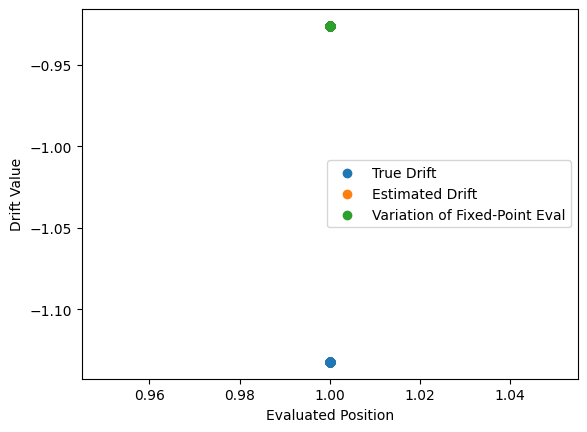

In [120]:
for d in range(1):
    plt.scatter(pos[:, d], true_drifts[:, d], label="True Drift")
    plt.scatter(pos[:, d], est_drifts[:, d], label="Estimated Drift")
    print(np.max(est_drifts[:, d])-np.min(est_drifts[:, d]))
    plt.scatter(pos[:, d], ownvariation_est_drifts[:, d], label="Variation of Fixed-Point Eval")
    plt.xlabel("Evaluated Position")
    plt.ylabel("Drift Value")
    plt.legend()
    plt.show()
    plt.close()
#0.1103, '129, 0.286, , 0.38